The dataset comes from [this website](https://www.cityscapes-dataset.com/dataset-overview/) and you can download it at [this direct link](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_gtFine_trainvaltest.zip).

In [2]:
import zipfile
import urllib

from url import file1_url, file2_url

# Will try to download the files

# Dataset archive whith labels
file_path = 'P8_Cityscapes_gtFine_trainvaltest.zip'
# Dataset archive with images
file_path_2 = 'P8_Cityscapes_leftImg8bit_trainvaltest.zip'

# Check if file exists
if not os.path.isfile(file_path):
    print(f'{file_path} archive does not exist. Downloading from internet...')
    urllib.request.urlretrieve(file1_url, file_path)
    print('Download complete.')

# Check if file exists
if not os.path.isfile(file_path_2):
    print(f'{file_path_2} archive does not exist. Downloading from internet...')
    urllib.request.urlretrieve(file2_url, file_path_2)
    print('Download complete.')


In [3]:
# Create another directory and extract the file in it
path_to_extract = f'dataset/'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract)

# Create another directory and extract the file in it
with zipfile.ZipFile(file_path_2, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract)

A faire :
- [x] Comprendre ce qu'est et pourquoi utiliser un "générateur à la volée". Script [ici](https://github.com/srihari-humbarwadi/cityscapes-segmentation-with-Unet/blob/master/batch_training.py).
  - Finalement le script a l'air d'avoir été fait avec un ancien générateur python. Au pire on aurait utilisé le mot clef yield mais mieux encore, il y a le tf.data.Dataset qui va nous aider à le faire.
- [ ] Définir quelles sont les variables dont on aura besoin pour entrainer notre modèle
- [ ] Créer un générateur pour récupérer ces données.
- [ ] Entrainer le modèle

Ressources :
1. Un guide classique sur la segmentation image avec exactement ce dataset [ici](https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html)
2. A entrainé Unet sur le dataset [ici](https://github.com/srihari-humbarwadi/cityscapes-segmentation-with-Unet)
3. Kaggle d'entrainement de PSPNet sur le dataset [ici](https://www.kaggle.com/code/santhalnr/cityscapes-image-segmentation-pspnet/notebook)
4. La doc de python [ici](https://docs.python.org/3/index.html)
   

1/1 [==============================] - 2s 2s/step


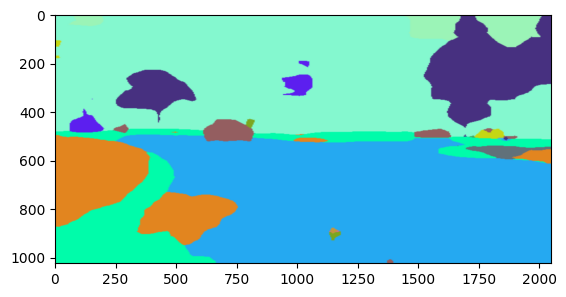

In [4]:
# Test of the module with pre-trained model

from keras_segmentation.pretrained import pspnet_50_ADE_20K

model = pspnet_50_ADE_20K()

in_name = r"C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\dataset\leftImg8bit\train\aachen\aachen_000000_000019_leftImg8bit.png"
out_name = "out.png"
out = model.predict_segmentation(
    inp=in_name,
    out_fname=out_name
)

import cv2
import matplotlib.pyplot as plt
# display the image

img = cv2.imread(out_name)
plt.imshow(img)

# Preparing the images for training and testing

We need to make two folders

Images Folder - For all the training images
Annotations Folder - For the corresponding ground truth segmentation images

The filenames of the annotation images should be same as the filenames of the RGB images.

The size of the annotation image for the corresponding RGB image should be same.

For each pixel in the RGB image, the class label of that pixel in the annotation image would be the value of the blue pixel.

In [32]:
# Without doing a generator, let's segment images and labelling

training_folder = r"dataset\leftImg8bit\train"

# List of all subfolders
subfolders = os.listdir(training_folder)

# List of all images paths in the subfolders
images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(training_folder, subfolder)):
        images.append(os.path.join(training_folder, subfolder, image))


# Same for labelling
labelling_folder = r"dataset\gtFine\train"

# List of all subfolders
subfolders = os.listdir(labelling_folder)

# List of all images paths in the subfolders
labels_images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(labelling_folder, subfolder)):
        if image.endswith('labelIds.png'):
            labels_images.append(os.path.join(labelling_folder, subfolder, image))

tuple_images_labels = list(zip(images, labels_images))


# Same for validation
validation_folder = r"dataset\leftImg8bit\val"

# List of all subfolders
subfolders = os.listdir(validation_folder)

# List of all images paths in the subfolders
val_images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(validation_folder, subfolder)):
        val_images.append(os.path.join(validation_folder, subfolder, image))


# Same for labelling
validation_labelling_folder = r"dataset\gtFine\train"

# List of all subfolders
subfolders = os.listdir(validation_labelling_folder)

# List of all images paths in the subfolders
val_labels_images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(validation_labelling_folder, subfolder)):
        if image.endswith('labelIds.png'):
            val_labels_images.append(os.path.join(validation_labelling_folder, subfolder, image))

tuple_val_images_labels = list(zip(val_images, val_labels_images))

In [40]:
import shutil
import os
import random

# Creating folder training_data
training_data_folder = r"processed_data\training_data"
if not os.path.exists(training_data_folder):
    os.makedirs(training_data_folder)

# Creating training_labels folder
training_labels_folder = r"processed_data\training_labels"
if not os.path.exists(training_labels_folder):
    os.makedirs(training_labels_folder)

for image, label in random.choices(tuple_images_labels, k=10):
    # get image name
    image_name = os.path.basename(image)[:-16] + '.png'
    # Copy image to training_data folder and rename it
    shutil.copy(image, os.path.join(training_data_folder, image_name))
    # Copy label to training_labels folder
    shutil.copy(label, os.path.join(training_labels_folder, image_name))




# Creating validation_data folder
validation_data_folder = r"processed_data\validation_data"
if not os.path.exists(validation_data_folder):
    os.makedirs(validation_data_folder)

# Creating validation_labels folder
validation_labels_folder = r"processed_data\validation_labels"
if not os.path.exists(validation_labels_folder):
    os.makedirs(validation_labels_folder)

for image, label in random.choices(tuple_val_images_labels, k=100):
    # get image name
    image_name = os.path.basename(image)[:-16] + '.png'
    # Copy image to validation_data_folder folder and rename it
    shutil.copy(image, os.path.join(validation_data_folder, image_name))
    # Copy label to validation_labels_folder folder
    shutil.copy(label, os.path.join(validation_labels_folder, image_name))

Let's resize everything

In [41]:
print("Resizing training images...")
for image_name in tqdm(os.listdir(training_data_folder)):
    cv2.resize(cv2.imread(os.path.join(training_data_folder, image_name)), [416, 608])
print("Done.")

print("Resizing training labels...")
for image in tqdm(os.listdir(training_labels_folder)):
    cv2.resize(cv2.imread(os.path.join(training_labels_folder, image_name)), [416, 608])
print("Done.")

print("Resizing validation images...")
for image_name in tqdm(os.listdir(validation_data_folder)):
    cv2.resize(cv2.imread(os.path.join(validation_data_folder, image_name)), [416, 608])
print("Done.")

print("Resizing validation labels...")
for image in tqdm(os.listdir(validation_labels_folder)):
    cv2.resize(cv2.imread(os.path.join(validation_labels_folder, image_name)), [416, 608])
print("Done.")

Resizing training images...


100%|██████████| 20/20 [00:00<00:00, 27.73it/s]


Done.
Resizing training labels...


100%|██████████| 20/20 [00:00<00:00, 80.39it/s]


Done.
Resizing validation images...


100%|██████████| 172/172 [00:06<00:00, 26.59it/s]


Done.
Resizing validation labels...


100%|██████████| 172/172 [00:01<00:00, 89.69it/s]

Done.


Let's convert id of the label to the category name.

In [36]:
import numpy as np
from labels import *

# Create dictionnary for {labelId : label}
id2categoryId = { int(label.id) : int(label.categoryId) for label in labels}

# Create a lambda function that returns the categoryId of a labelId
getCatId = lambda labelId: id2categoryId[labelId]

# Create a vectorized function
matrixId2categoryId = np.vectorize(getCatId)

Different values with the labels id : [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]


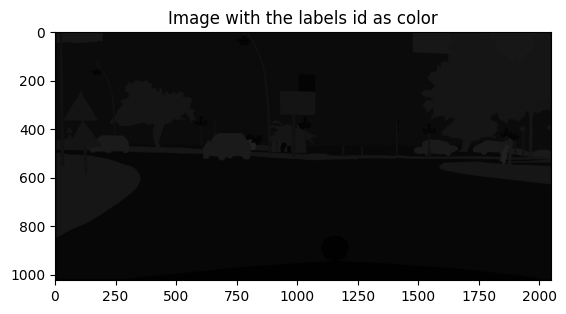

Different values with the categories id : [0 1 2 3 4 5 6 7]


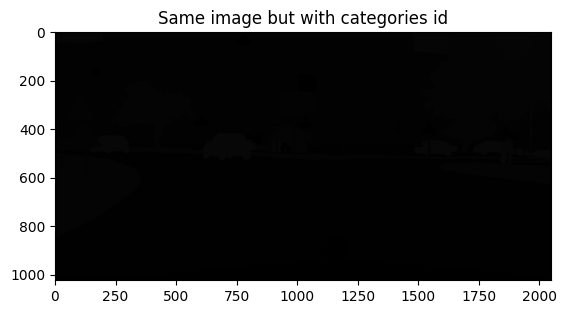

In [37]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread(r"C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\dataset\gtFine\train\aachen\aachen_000000_000019_gtFine_labelIds.png", cv2.IMREAD_COLOR)
print(f"Different values with the labels id : {np.unique(image)}")
plt.imshow(image)
plt.title("Image with the labels id as color")
plt.show()


image = matrixId2categoryId(image)

print(f"Different values with the categories id : {np.unique(image)}")
image = image.astype(np.uint8)
plt.imshow(image)
plt.title("Same image but with categories id")
plt.show()

In [43]:
from tqdm.autonotebook import tqdm

# Not optimal at all
print("Converting training annotations to categories id...")
for image in tqdm(os.listdir(training_labels_folder)):
    # Read image
    img = cv2.imread(os.path.join(training_labels_folder, image), cv2.IMREAD_COLOR)
    # Convert image to categorical
    img = matrixId2categoryId(img)
    # Save image
    cv2.imwrite(os.path.join(training_labels_folder, image), img)
print("Done.")

print("Converting validation annotations to categories id...")
for image in tqdm(os.listdir(validation_labels_folder)):
    # Read image
    img = cv2.imread(os.path.join(validation_labels_folder, image), cv2.IMREAD_COLOR)
    # Convert image to categorical
    img = matrixId2categoryId(img)
    # Save image
    cv2.imwrite(os.path.join(validation_labels_folder, image), img)
print("Done.")

Converting training annotations to categories id...


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Done.
Converting validation annotations to categories id...


100%|██████████| 172/172 [01:32<00:00,  1.87it/s]

Done.


# Need to use the GPU

# Maybe use a less efficient version of the model (FCN8 ?)

In [46]:
# Need to use the GPU
# Maybe use a less efficient version of the model (FCN8 ?)

from keras_segmentation.models.unet import vgg_unet

model = vgg_unet(n_classes=8 ,  input_height=416, input_width=608)

# Creating checkpoint folder
checkpoint_folder = r"tmp\vgg_unet_1"
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)


history = model.train(
            train_images =  training_data_folder,
            train_annotations = training_labels_folder,
            checkpoints_path = checkpoint_folder, epochs=5,)


Verifying training dataset


100%|██████████| 20/20 [00:01<00:00, 17.83it/s]
c:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\env\lib\site-packages\keras_segmentation\train.py:156: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, steps_per_epoch,


Dataset verified! 
Epoch 1/5
359/512 [====================>.........] - ETA: 1:48:43 - loss: 2.5366 - accuracy: 0.2092

KeyboardInterrupt: 

1/1 [==============================] - 1s 827ms/step


0it [00:00, ?it/s]

1/1 [==============================] - 1s 660ms/step


1it [00:00,  1.27it/s]

1/1 [==============================] - 1s 682ms/step


2it [00:01,  1.26it/s]

1/1 [==============================] - 1s 676ms/step


3it [00:02,  1.25it/s]

1/1 [==============================] - 1s 718ms/step


4it [00:03,  1.20it/s]

1/1 [==============================] - 1s 694ms/step


5it [00:04,  1.20it/s]

1/1 [==============================] - 1s 673ms/step


6it [00:04,  1.21it/s]

1/1 [==============================] - 1s 662ms/step


7it [00:05,  1.23it/s]

1/1 [==============================] - 1s 690ms/step


8it [00:06,  1.24it/s]

1/1 [==============================] - 1s 686ms/step


9it [00:07,  1.24it/s]

1/1 [==============================] - 1s 663ms/step


10it [00:08,  1.25it/s]

1/1 [==============================] - 1s 649ms/step


11it [00:08,  1.27it/s]

1/1 [==============================] - 1s 645ms/step


12it [00:09,  1.28it/s]

1/1 [==============================] - 1s 644ms/step


13it [00:10,  1.29it/s]

1/1 [==============================] - 1s 659ms/step


14it [00:11,  1.29it/s]

1/1 [==============================] - 1s 663ms/step


15it [00:11,  1.28it/s]

1/1 [==============================] - 1s 694ms/step


16it [00:13,  1.11it/s]

1/1 [==============================] - 1s 721ms/step


17it [00:14,  1.15it/s]


KeyboardInterrupt: 

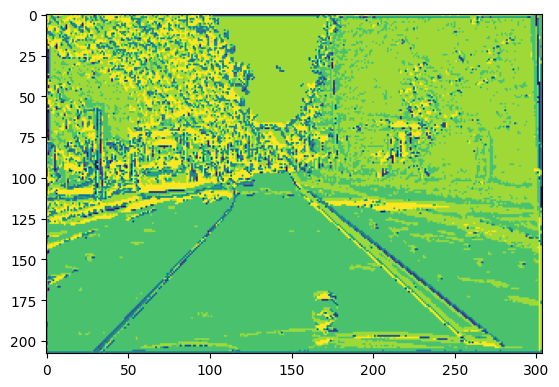

In [45]:
out = model.predict_segmentation(
    inp=r"C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\processed_data\validation_data\munster_000134_000019.png",
    out_fname="out.png"
)

import matplotlib.pyplot as plt
plt.imshow(out)

# evaluating the model 
print(model.evaluate_segmentation(inp_images_dir=validation_data_folder  , annotations_dir=validation_labels_folder ) )